# Sumário

[Funções de Ativação](#Funções-de-Ativação)

[Funções Auxiliares](#Funções-Auxiliares)

[Funções de Custo](#Funções-de-Custo)

[Inicialização de Pesos](#Inicialização-de-Pesos)

[Regularização](#Regularização)

[Learning Rate Decay](#Learning-Rate-Decay)

[Batch Normalization](#Batch-Normalization)

[Batch Generator](#Batch-Generator)

[Implementação](#Implementação)

[Testes da Implementação](#Testes-da-Implementação)

- [Exemplos do Notebook da Intuição](#Exemplos-do-Notebook-da-Intuição)

- [Regressão](#Regressão)
    - [Regressão Linear Simples](#Regressão-Linear-Simples---Exemplo-do-Perceptron)
    - [Regressão Linear Multivariada](#Regressão-Linear-Multivariada---Exerc%C3%ADcio-de-Regressão-do-Perceptron)
    - [Regressão Quadrática](#Regressão-Quadrática)
    - [Regressão Cúbica](#Regressão-Cúbica)
    - [Regressão Logarítimica](#Regressão-Logar%C3%ADtimica)
    - [Regressão Exponencial](#Regressão-Exponencial)

- [Classificação Binária](#Classificação-Binária)
    - [Porta AND/OR](#Porta-AND/OR)
    - [Porta XOR](#Porta-XOR)
    - [2 Clusters](#2-Clusters)
    - [4 Clusters](#4-Clusters)
    - [Círculos](#C%C3%ADrculos)
    - [Moons](#Moons)
    - [Espiral](#Espiral)
    
- [Classificação Multiclasse](#Classificação-Multiclasse)
    - [3 Clusters Multiclasse](#3-Clusters-Multiclasse)
    - [4 Clusters Multiclasse](#4-Clusters-Multiclasse)
    - [Espiral - 5 Classes](#Espiral---5-Classes)
    - [Make Classification - 4 Classes](#Make-Classification---4-Classes)
    - [Iris Dataset](#Iris-Dataset)

[Referências](#Referências)

# Imports and Configurações

In [1]:
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.datasets.samples_generator import make_blobs, make_circles, make_moons, make_classification
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import plots
from utils.samples_generator import make_spiral, make_square, make_cubic, make_exp, make_log10
from utils.grad_check import gradient_checking

%matplotlib inline

# Funções de Ativação

In [2]:
def linear(x, derivative=False):
    return np.ones_like(x) if derivative else x

def sigmoid(x, derivative=False):
    if derivative:
        y = sigmoid(x)
        return y*(1 - y)
    return 1.0/(1.0 + np.exp(-x))

def tanh(x, derivative=False):
    if derivative:
        y = tanh(x)
        return 1 - y**2
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def relu(x, derivative=False):
    if derivative:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

def leaky_relu(x, derivative=False):
    alpha = 0.1
    if derivative:
        return np.where(x <= 0, alpha, 1)
    return np.where(x <= 0, alpha*x, x)

def elu(x, derivative=False):
    alpha = 1.0
    if derivative:
        y = elu(x)
        return np.where(x <= 0, y + alpha, 1)
    return np.where(x <= 0, alpha*(np.exp(x) - 1), x)

# Funções Auxiliares

In [3]:
def softmax(x, y_oh=None, derivative=False):
    if derivative: 
        y_pred = softmax(x)
        y_correct = np.argmax(y_oh, axis=1)
        pk = y_pred[range(y_pred.shape[0]), y_correct]
        y_pred[range(y_pred.shape[0]), y_correct] = pk*(1.0 - pk)
        return y_pred
    exp = np.exp(x)
    return exp/np.sum(exp, axis=1, keepdims=True)

def neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_pred[range(y_pred.shape[0]), y_correct]
    if derivative:
        y_pred[range(y_pred.shape[0]), y_correct] = (-1.0/pk)
        return y_pred
    return np.mean(-np.log(pk))

# Funções de Custo

###### Para Regressão

In [4]:
def mae(y, y_pred, derivative=False):
    if derivative:
        return np.where(y_pred > y, 1, -1) / y.shape[0]
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / y.shape[0]
    return 0.5*np.mean((y - y_pred)**2)

###### Para Classificação Binária

In [5]:
def binary_cross_entropy(y, y_pred, derivative=False):
    if derivative:
        return -(y - y_pred) / (y_pred * (1-y_pred) * y.shape[0])
    return -np.mean(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def sigmoid_cross_entropy(y, y_pred, derivative=False):
    y_sigmoid = sigmoid(y_pred)
    if derivative:
        return -(y - y_sigmoid) / y.shape[0]
    return -np.mean(y*np.log(y_sigmoid) + (1-y)*np.log(1-y_sigmoid))

###### Para Classificação Multiclasse

In [6]:
def softmax_neg_log_likelihood(y_oh, y_pred, derivative=False):
    y_softmax = softmax(y_pred)
    y_correct = np.argmax(y_oh, axis=1)
    pk = y_softmax[range(y_softmax.shape[0]), y_correct]
    if derivative:
        return -(y_oh - y_softmax)/y_oh.shape[0]
    return np.mean(-np.log(pk))

# Inicialização de Pesos

In [7]:
def zeros(rows, cols):
    return np.zeros((rows, cols))

def ones(rows, cols):
    return np.ones((rows, cols))

def random_normal(rows, cols):
    return np.random.randn(rows, cols)

def random_uniform(rows, cols):
    return np.random.rand(rows, cols)

def glorot_normal(rows, cols):
    # normal com media=0 e stddev=sqrt(2.0 / (out + inp)). Ver notas de np.random.randn.
    std_dev = np.sqrt(2.0 / (rows + cols))
    return std_dev*np.random.randn(rows, cols)

def glorot_uniform(rows, cols):
    # uniforme de [-limit, limit], onde limit = np.sqrt(6.0 / (out + inp))
    limit = np.sqrt(6.0 / (rows + cols))
    return 2*limit*np.random.rand(rows, cols) - limit

# Regularização

In [8]:
def l1_regularization(weights, derivative=False):
    if derivative:
        weights = [np.where(w < 0, -1, w) for w in weights]
        return np.array([np.where(w > 0, 1, w) for w in weights])
    return np.sum([np.sum(np.abs(w)) for w in weights])

def l2_regularization(weights, derivative=False):
    if derivative:
        return weights
    return 0.5 * np.sum(weights**2)

# Batch Generator

In [11]:
def batch_sequential(x, y, batch_size=None):
    batch_size = x.shape[0] if batch_size is None else batch_size
    n_batches = x.shape[0] // batch_size
    
    for batch in range(n_batches):
        offset = batch_size * batch
        x_batch, y_batch = x[offset:offset+batch_size], y[offset:offset+batch_size]
        yield (x_batch, y_batch)
    
def batch_shuffle(x, y, batch_size=None):
    shuffle_index = np.random.permutation(range(x.shape[0]))
    return batch_sequential(x[shuffle_index], y[shuffle_index], batch_size)

# Learning Rate Decay

In [9]:
def none_decay(learning_rate, epoch, decay_rate, decay_step=1):
    return learning_rate

def time_based_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return 1.0 / (1 + decay_rate * epoch)

def exponential_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**epoch

def staircase_decay(learning_rate, epoch, decay_rate, decay_steps=1):
    return learning_rate * decay_rate**(epoch // decay_steps)

# Batch Normalization 

In [10]:
def batchnorm_forward(layer, x, is_training=True):
    mu = np.mean(x, axis=0) if is_training else layer._pop_mean
    var = np.var(x, axis=0) if is_training else layer._pop_var
    x_norm = (x - mu) / np.sqrt(var + 1e-8)
    out = layer.gamma * x_norm + layer.beta

    if is_training:
        layer._pop_mean = layer.bn_decay * layer._pop_mean + (1.0-layer.bn_decay)*mu
        layer._pop_var = layer.bn_decay * layer._pop_var + (1.0-layer.bn_decay)*var
        layer._bn_cache = (x, x_norm, mu, var)
    return out

def batchnorm_backward(layer, dactivation):
    x, x_norm, mu, var = layer._bn_cache

    m = layer._activ_inp.shape[0]
    x_mu = x - mu
    std_inv = 1. / np.sqrt(var + 1e-8)

    dx_norm = dactivation * layer.gamma
    dvar = np.sum(dx_norm * x_mu, axis=0) * -0.5 * (std_inv**3)
    dmu = np.sum(dx_norm * -std_inv, axis=0) + dvar * np.mean(-2.0 * x_mu, axis=0)

    dx = (dx_norm * std_inv) + (dvar * 2.0 * x_mu / m) + (dmu / m)
    layer._dgamma = np.sum(dactivation * x_norm, axis=0)
    layer._dbeta = np.sum(dactivation, axis=0)
    return dx

# Implementação 

In [12]:
class Layer():
    def __init__(self, input_dim, output_dim, activation=linear, weights_initializer=random_normal, biases_initializer=ones, dropout_prob=0.0, reg_func=l2_regularization, reg_strength=0.0, batch_norm=False, bn_decay=0.9, is_trainable=True):
        self.input = None
        self.weights = weights_initializer(output_dim, input_dim)
        self.biases = biases_initializer(1, output_dim)
        self.activation = activation
        self.dropout_prob = dropout_prob
        self.reg_func = reg_func
        self.reg_strength = reg_strength
        self.batch_norm = batch_norm
        self.bn_decay = bn_decay
        self.gamma, self.beta = ones(1, output_dim), zeros(1, output_dim)
        self.is_trainable = is_trainable

        self._activ_inp, self._activ_out = None, None
        self._dweights, self._dbiases, self._prev_dweights = None, None, 0.0
        self._dropout_mask = None
        self._dgamma, self._dbeta = None, None
        self._pop_mean, self._pop_var = zeros(1, output_dim), zeros(1, output_dim)
        self._bn_cache = None

class NeuralNetwork():
    def __init__(self, cost_func=mse, learning_rate=1e-3, lr_decay_method=none_decay, lr_decay_rate=0.0, lr_decay_steps=1, momentum=0.0, patience=np.inf):
        self.layers = []
        self.cost_func = cost_func
        self.learning_rate = self.lr_initial = learning_rate
        self.lr_decay_method = lr_decay_method
        self.lr_decay_rate = lr_decay_rate
        self.lr_decay_steps = lr_decay_steps
        self.momentum = momentum
        self.patience, self.waiting = patience, 0
        self._best_model, self._best_loss = self.layers, np.inf
        
    def fit(self, x_train, y_train, x_val=None, y_val=None, epochs=100, verbose=10, batch_gen=batch_sequential, batch_size=None):
        x_val, y_val = (x_train, y_train) if (x_val is None or y_val is None) else (x_val, y_val)

        for epoch in range(epochs+1):
            self.learning_rate = self.lr_decay_method(self.lr_initial, epoch, self.lr_decay_rate, self.lr_decay_steps)

            for x_batch, y_batch in batch_gen(x_train, y_train, batch_size):
                y_pred = self.__feedforward(x_batch)
                self.__backprop(y_batch, y_pred)

            loss_val = self.cost_func(y_val, self.predict(x_val))
            if loss_val < self._best_loss:
                self._best_model, self._best_loss = self.layers, loss_val
                self.waiting = 0
            else:
                self.waiting += 1
                if self.waiting >= self.patience:
                    self.layers = self._best_model
                    return
            
            if epoch % verbose == 0:
                loss_train = self.cost_func(y_train, self.predict(x_train))
                loss_reg = (1.0/y_train.shape[0])*np.sum([layer.reg_strength * layer.reg_func(layer.weights) for layer in self.layers])
                print("epoch: {0:=4}/{1} loss_train: {2:.8f} + {3:.8f} = {4:.8f} loss_val = {5:.8f}".format(epoch, epochs, loss_train, loss_reg, loss_train + loss_reg, loss_val))
        
    def predict(self, x):
        return self.__feedforward(x, is_training=False)

    def save(self, file_path):
        pkl.dump(self, open(file_path, 'wb'), -1)
    
    def load(file_path):
        return pkl.load(open(file_path, 'rb'))
    
    def __feedforward(self, x, is_training=True):
        self.layers[0].input = x
        for current_layer, next_layer in zip(self.layers, self.layers[1:] + [Layer(0, 0)]):
            y = np.dot(current_layer.input, current_layer.weights.T) + current_layer.biases
            y = batchnorm_forward(current_layer, y, is_training) if current_layer.batch_norm else y
            current_layer._dropout_mask = np.random.binomial(1, 1.0-current_layer.dropout_prob, y.shape) / (1.0-current_layer.dropout_prob)
            current_layer._activ_inp = y
            current_layer._activ_out = current_layer.activation(y) * (current_layer._dropout_mask if is_training else 1.0)
            next_layer.input = current_layer._activ_out
        return self.layers[-1]._activ_out
    
    def __backprop(self, y, y_pred):
        last_delta = self.cost_func(y, y_pred, derivative=True)
        for layer in reversed(self.layers):
            dactivation = layer.activation(layer._activ_inp, derivative=True) * last_delta * layer._dropout_mask
            dactivation = batchnorm_backward(layer, dactivation) if layer.batch_norm else dactivation
            last_delta = np.dot(dactivation, layer.weights)
            layer._dweights = np.dot(dactivation.T, layer.input)
            layer._dbiases = 1.0*dactivation.sum(axis=0, keepdims=True)
        
        for layer in reversed(self.layers):
            if layer.is_trainable:
                layer._dweights = layer._dweights + (1.0/y.shape[0]) * layer.reg_strength * layer.reg_func(layer.weights, derivative=True)
                layer._prev_dweights = -self.learning_rate*layer._dweights + self.momentum*layer._prev_dweights
                layer.weights = layer.weights + layer._prev_dweights
                layer.biases = layer.biases - self.learning_rate*layer._dbiases
                if layer.batch_norm:
                    layer.gamma = layer.gamma - self.learning_rate*layer._dgamma
                    layer.beta = layer.beta - self.learning_rate*layer._dbeta

## Exemplos do Notebook da Intuição

### Exemplo 1

In [13]:
x = np.array([[0.05, 0.10]])
y = np.array([[0.01, 0.99]])

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=0.5)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=sigmoid))

w1 = np.array([[0.15, 0.20], [0.25, 0.30]])
b1 = np.array([[0.35]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)
w2 = np.array([[0.40, 0.45], [0.50, 0.55]])
b2 = np.array([[0.60]]) # destacar que eram para ser 2 bias - um para cada neurônio (1, 2)

nn.layers[0].weights = w1
nn.layers[0].biases = b1
nn.layers[1].weights = w2
nn.layers[1].biases = b2

nn.fit(x, y, epochs=0, verbose=1)

for layer in nn.layers:
    print(layer.weights)

epoch:    0/0 loss_train: 0.14023572 + 0.00000000 = 0.14023572 loss_val = 0.14023572
[[0.14978072 0.19956143]
 [0.24975114 0.29950229]]
[[0.35891648 0.40866619]
 [0.51130127 0.56137012]]


### Exemplo 2

In [14]:
x = np.array([[0.1, 0.2, 0.7]])
y = np.array([[1, 0, 0]])
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=0.01)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=3, activation=sigmoid))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

w1 = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.7], [0.4, 0.3, 0.9]])
b1 = np.ones((1,3))
w2 = np.array([[0.2, 0.3, 0.5], [0.3, 0.5, 0.7], [0.6, 0.4, 0.8]])
b2 = np.ones((1,3))
w3 = np.array([[0.1, 0.4, 0.8], [0.3, 0.7, 0.2], [0.5, 0.2, 0.9]])
b3 = np.ones((1,3))

for i, w, b in zip(range(3), [w1, w2, w3], [b1, b2, b3]):
    nn.layers[i].weights = w
    nn.layers[i].biases = b

nn.fit(x, y, epochs=300, verbose=30)
for layer in nn.layers:
    print(layer.weights)

for layer in nn.layers:
    layer.is_trainable = False

print("Trainable == FALSE")
nn.fit(x, y, epochs=1000, verbose=100)
for layer in nn.layers:
    print(layer.weights)

epoch:    0/300 loss_train: 1.14054966 + 0.00000000 = 1.14054966 loss_val = 1.14054966
epoch:   30/300 loss_train: 0.59630022 + 0.00000000 = 0.59630022 loss_val = 0.59630022
epoch:   60/300 loss_train: 0.36031189 + 0.00000000 = 0.36031189 loss_val = 0.36031189
epoch:   90/300 loss_train: 0.24668884 + 0.00000000 = 0.24668884 loss_val = 0.24668884
epoch:  120/300 loss_train: 0.18386202 + 0.00000000 = 0.18386202 loss_val = 0.18386202
epoch:  150/300 loss_train: 0.14510157 + 0.00000000 = 0.14510157 loss_val = 0.14510157
epoch:  180/300 loss_train: 0.11918285 + 0.00000000 = 0.11918285 loss_val = 0.11918285
epoch:  210/300 loss_train: 0.10078511 + 0.00000000 = 0.10078511 loss_val = 0.10078511
epoch:  240/300 loss_train: 0.08712037 + 0.00000000 = 0.08712037 loss_val = 0.08712037
epoch:  270/300 loss_train: 0.07660623 + 0.00000000 = 0.07660623 loss_val = 0.07660623
epoch:  300/300 loss_train: 0.06828531 + 0.00000000 = 0.06828531 loss_val = 0.06828531
[[0.10083595 0.2016719  0.30585165]
 [0.300

## Gradient Checking

In [15]:
np.random.seed(1234)
N, D = 100, 2
x = np.random.rand(N, D)
y = np.random.rand(N, 1)

In [20]:
# regression
D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9, lr_decay_method=staircase_decay, lr_decay_rate=0.5, lr_decay_steps=10)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 9.15147775 + 0.06865920 = 9.22013695 loss_val = 9.15147775
epoch:   10/100 loss_train: 0.61120870 + 0.06646591 = 0.67767462 loss_val = 0.61120870
epoch:   20/100 loss_train: 0.59693797 + 0.06486552 = 0.66180349 loss_val = 0.59693797
epoch:   30/100 loss_train: 0.58456335 + 0.06407408 = 0.64863743 loss_val = 0.58456335
epoch:   40/100 loss_train: 0.58009647 + 0.06368199 = 0.64377846 loss_val = 0.58009647
epoch:   50/100 loss_train: 0.57916663 + 0.06348689 = 0.64265352 loss_val = 0.57916663
epoch:   60/100 loss_train: 0.57949652 + 0.06338959 = 0.64288611 loss_val = 0.57949652
epoch:   70/100 loss_train: 0.58002911 + 0.06334101 = 0.64337012 loss_val = 0.58002911
epoch:   80/100 loss_train: 0.58042486 + 0.06331674 = 0.64374160 loss_val = 0.58042486
epoch:   90/100 loss_train: 0.58065610 + 0.06330461 = 0.64396071 loss_val = 0.58065610
epoch:  100/100 loss_train: 0.58078071 + 0.06329855 = 0.64407926 loss_val = 0.58078071
epoch:    0/0 loss_train: 0.57899023 + 0.06

In [18]:
# binary classification
y = np.random.randint(0, 2, (N, 1))

D_in, D_out = x.shape[1], y.shape[1]
nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 1.20012602 + 0.04732879 = 1.24745481 loss_val = 1.20012602
epoch:   10/100 loss_train: 0.89302024 + 0.04728196 = 0.94030220 loss_val = 0.89302024
epoch:   20/100 loss_train: 0.70757407 + 0.04720130 = 0.75477537 loss_val = 0.70757407
epoch:   30/100 loss_train: 0.77483407 + 0.04710908 = 0.82194315 loss_val = 0.77483407
epoch:   40/100 loss_train: 0.78986723 + 0.04701301 = 0.83688023 loss_val = 0.78986723
epoch:   50/100 loss_train: 0.79236295 + 0.04691573 = 0.83927868 loss_val = 0.79236295
epoch:   60/100 loss_train: 0.79209569 + 0.04681811 = 0.83891380 loss_val = 0.79209569
epoch:   70/100 loss_train: 0.79106106 + 0.04672045 = 0.83778151 loss_val = 0.79106106
epoch:   80/100 loss_train: 0.78982043 + 0.04662285 = 0.83644327 loss_val = 0.78982043
epoch:   90/100 loss_train: 0.78854477 + 0.04652531 = 0.83507008 loss_val = 0.78854477
epoch:  100/100 loss_train: 0.78724699 + 0.04642788 = 0.83367487 loss_val = 0.78724699
epoch:    0/0 loss_train: 0.78711775 + 0.04

In [19]:
# multiclass classification
y = np.random.randint(0, 2, (N, 1))
y_oh = OneHotEncoder(sparse=False).fit_transform(y)

D_in, D_out = x.shape[1], y_oh.shape[1]
nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu, reg_func=l2_regularization, reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=4, output_dim=1, activation=tanh, reg_func=l1_regularization, reg_strength=1e-4))
nn.layers.append(Layer(input_dim=1, output_dim=2, activation=sigmoid, reg_func=l1_regularization,reg_strength=1.0, batch_norm=True))
nn.layers.append(Layer(input_dim=2, output_dim=5, activation=leaky_relu, reg_func=l2_regularization, reg_strength=1e-2))
nn.layers.append(Layer(input_dim=5, output_dim=3, activation=elu, reg_func=l1_regularization, reg_strength=1e-3, batch_norm=True))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=1e-3, batch_norm=True))

nn.fit(x, y, epochs=100)
gradient_checking(nn, x, y_oh, eps=1e-4, verbose=True)

epoch:    0/100 loss_train: 67.28808075 + 0.04672671 = 67.33480746 loss_val = 67.28808075
epoch:   10/100 loss_train: 3.22644261 + 0.04669660 = 3.27313921 loss_val = 3.22644261
epoch:   20/100 loss_train: 0.95914394 + 0.04664496 = 1.00578889 loss_val = 0.95914394
epoch:   30/100 loss_train: 0.96924664 + 0.04658593 = 1.01583257 loss_val = 0.96924664
epoch:   40/100 loss_train: 0.96927769 + 0.04652439 = 1.01580209 loss_val = 0.96927769
epoch:   50/100 loss_train: 1.07712609 + 0.04646214 = 1.12358823 loss_val = 1.07712609
epoch:   60/100 loss_train: 1.26355325 + 0.04639997 = 1.30995323 loss_val = 1.26355325
epoch:   70/100 loss_train: 1.58309618 + 0.04634007 = 1.62943625 loss_val = 1.58309618
epoch:   80/100 loss_train: 0.72097930 + 0.04628347 = 0.76726277 loss_val = 0.72097930
epoch:   90/100 loss_train: 0.75382296 + 0.04622543 = 0.80004839 loss_val = 0.75382296
epoch:  100/100 loss_train: 0.68040159 + 0.04616572 = 0.72656731 loss_val = 0.68040159
epoch:    0/0 loss_train: 0.68766242 + 0

## Regressão

### Regressão Linear Simples - Exemplo do Perceptron

In [20]:
data = np.loadtxt('data/medidas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,0].reshape(-1,1), data[:,1].reshape(-1,1)
print(x.shape, y.shape)

(100, 2)
(100, 1) (100, 1)


In [21]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(), x.max())

-1.0 0.9999999999999991


epoch:    0/1000 loss_train: 2315.28238644 + 0.00000000 = 2315.28238644 loss_val = 2315.28238644
epoch:  100/1000 loss_train: 15.79196354 + 0.00000000 = 15.79196354 loss_val = 15.79196354
epoch:  200/1000 loss_train: 13.10651964 + 0.00000000 = 13.10651964 loss_val = 13.10651964
epoch:  300/1000 loss_train: 13.04300211 + 0.00000000 = 13.04300211 loss_val = 13.04300211
epoch:  400/1000 loss_train: 13.04152255 + 0.00000000 = 13.04152255 loss_val = 13.04152255
epoch:  500/1000 loss_train: 13.04146224 + 0.00000000 = 13.04146224 loss_val = 13.04146224
epoch:  600/1000 loss_train: 13.04146371 + 0.00000000 = 13.04146371 loss_val = 13.04146371
epoch:  700/1000 loss_train: 13.04145805 + 0.00000000 = 13.04145805 loss_val = 13.04145805
epoch:  800/1000 loss_train: 13.04145802 + 0.00000000 = 13.04145802 loss_val = 13.04145802
epoch:  900/1000 loss_train: 13.04146129 + 0.00000000 = 13.04146129 loss_val = 13.04146129
epoch: 1000/1000 loss_train: 13.04147039 + 0.00000000 = 13.04147039 loss_val = 13.04

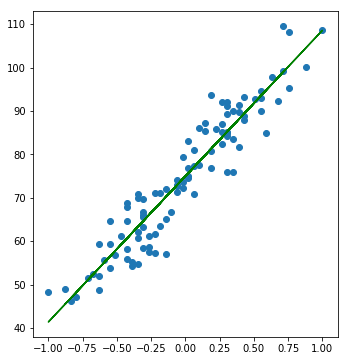

In [22]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-2)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))

nn.fit(x, y, batch_gen=batch_shuffle, batch_size=10, epochs=1000, verbose=100)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Linear Multivariada - Exercício de Regressão do Perceptron

In [23]:
data = np.loadtxt('data/notas.csv', delimiter=',', skiprows=1)
print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape, y.shape)

(25, 4)
(25, 3) (25, 1)


In [24]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1. -1. -1.] [1. 1. 1.]


In [25]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear))
nn.fit(x, y, epochs=2000, verbose=200)

print(nn.layers[0].weights)
print(nn.layers[0].biases)

epoch:    0/2000 loss_train: 10028.66247450 + 0.00000000 = 10028.66247450 loss_val = 10028.66247450
epoch:  200/2000 loss_train: 6.72062274 + 0.00000000 = 6.72062274 loss_val = 6.72062274
epoch:  400/2000 loss_train: 3.95609835 + 0.00000000 = 3.95609835 loss_val = 3.95609835
epoch:  600/2000 loss_train: 3.21042559 + 0.00000000 = 3.21042559 loss_val = 3.21042559
epoch:  800/2000 loss_train: 2.98847422 + 0.00000000 = 2.98847422 loss_val = 2.98847422
epoch: 1000/2000 loss_train: 2.91468236 + 0.00000000 = 2.91468236 loss_val = 2.91468236
epoch: 1200/2000 loss_train: 2.88755003 + 0.00000000 = 2.88755003 loss_val = 2.88755003
epoch: 1400/2000 loss_train: 2.87679132 + 0.00000000 = 2.87679132 loss_val = 2.87679132
epoch: 1600/2000 loss_train: 2.87231216 + 0.00000000 = 2.87231216 loss_val = 2.87231216
epoch: 1800/2000 loss_train: 2.87039358 + 0.00000000 = 2.87039358 loss_val = 2.87039358
epoch: 2000/2000 loss_train: 2.86955884 + 0.00000000 = 2.86955884 loss_val = 2.86955884
[[ 8.92473 13.98524 

### Regressão Quadrática

In [26]:
x, y = make_square(n_samples=100, x_min=-10, x_max=10, a=1, b=1, c=1, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [27]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/3000 loss_train: 1034.52654237 + 0.00000000 = 1034.52654237 loss_val = 1034.52654237
epoch:  300/3000 loss_train: 34.31768886 + 0.00000000 = 34.31768886 loss_val = 34.31768886
epoch:  600/3000 loss_train: 23.84942589 + 0.00000000 = 23.84942589 loss_val = 23.84942589
epoch:  900/3000 loss_train: 21.18386401 + 0.00000000 = 21.18386401 loss_val = 21.18386401
epoch: 1200/3000 loss_train: 53.27920541 + 0.00000000 = 53.27920541 loss_val = 53.27920541
epoch: 1500/3000 loss_train: 19.58398744 + 0.00000000 = 19.58398744 loss_val = 19.58398744
epoch: 1800/3000 loss_train: 18.32094911 + 0.00000000 = 18.32094911 loss_val = 18.32094911
epoch: 2100/3000 loss_train: 19.30203626 + 0.00000000 = 19.30203626 loss_val = 19.30203626
epoch: 2400/3000 loss_train: 17.82691420 + 0.00000000 = 17.82691420 loss_val = 17.82691420
epoch: 2700/3000 loss_train: 18.86436604 + 0.00000000 = 18.86436604 loss_val = 18.86436604
epoch: 3000/3000 loss_train: 17.44046343 + 0.00000000 = 17.44046343 loss_val = 17.44

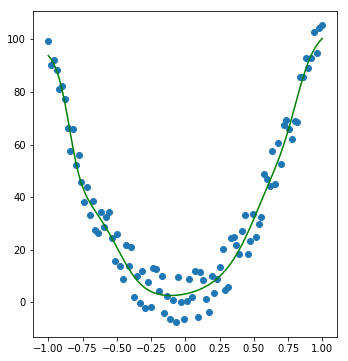

In [28]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=3000, verbose=300)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Cúbica

In [29]:
x, y = make_cubic(n_samples=100, x_min=-4, x_max=4, a=1, b=0, c=-10, d=0, noise=3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [30]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 47.93785463 + 0.00000000 = 47.93785463 loss_val = 47.93785463
epoch:  100/1000 loss_train: 27.40528409 + 0.00000000 = 27.40528409 loss_val = 27.40528409
epoch:  200/1000 loss_train: 13.26373439 + 0.00000000 = 13.26373439 loss_val = 13.26373439
epoch:  300/1000 loss_train: 6.16512167 + 0.00000000 = 6.16512167 loss_val = 6.16512167
epoch:  400/1000 loss_train: 4.04957656 + 0.00000000 = 4.04957656 loss_val = 4.04957656
epoch:  500/1000 loss_train: 2.76741547 + 0.00000000 = 2.76741547 loss_val = 2.76741547
epoch:  600/1000 loss_train: 2.25854045 + 0.00000000 = 2.25854045 loss_val = 2.25854045
epoch:  700/1000 loss_train: 2.02451325 + 0.00000000 = 2.02451325 loss_val = 2.02451325
epoch:  800/1000 loss_train: 1.88472919 + 0.00000000 = 1.88472919 loss_val = 1.88472919
epoch:  900/1000 loss_train: 1.78571246 + 0.00000000 = 1.78571246 loss_val = 1.78571246
epoch: 1000/1000 loss_train: 1.70154742 + 0.00000000 = 1.70154742 loss_val = 1.70154742


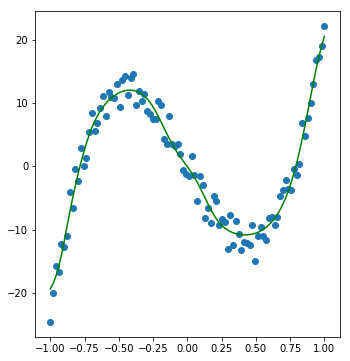

In [31]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Logarítimica

In [32]:
x, y = make_log10(n_samples=100, x_min=1, x_max=100, noise=0.3)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [33]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 0.35599965 + 0.00000000 = 0.35599965 loss_val = 0.35599965
epoch:  100/1000 loss_train: 0.01790507 + 0.00000000 = 0.01790507 loss_val = 0.01790507
epoch:  200/1000 loss_train: 0.01647642 + 0.00000000 = 0.01647642 loss_val = 0.01647642
epoch:  300/1000 loss_train: 0.01579756 + 0.00000000 = 0.01579756 loss_val = 0.01579756
epoch:  400/1000 loss_train: 0.01541787 + 0.00000000 = 0.01541787 loss_val = 0.01541787
epoch:  500/1000 loss_train: 0.01519478 + 0.00000000 = 0.01519478 loss_val = 0.01519478
epoch:  600/1000 loss_train: 0.01506179 + 0.00000000 = 0.01506179 loss_val = 0.01506179
epoch:  700/1000 loss_train: 0.01498132 + 0.00000000 = 0.01498132 loss_val = 0.01498132
epoch:  800/1000 loss_train: 0.01493147 + 0.00000000 = 0.01493147 loss_val = 0.01493147
epoch:  900/1000 loss_train: 0.01489960 + 0.00000000 = 0.01489960 loss_val = 0.01489960
epoch: 1000/1000 loss_train: 0.01487843 + 0.00000000 = 0.01487843 loss_val = 0.01487843


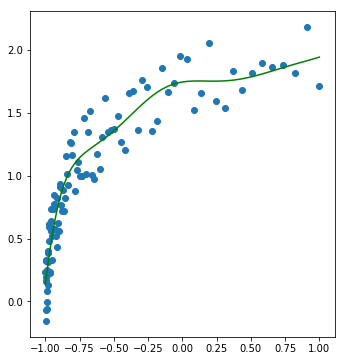

In [34]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=tanh))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

### Regressão Exponencial

In [35]:
x, y = make_exp(n_samples=100, x_min=0, x_max=5, noise=10)

print(x.shape, y.shape)

(100, 1) (100, 1)


In [36]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))

print(x.min(axis=0), x.max(axis=0))

[-1.] [1.]


epoch:    0/1000 loss_train: 1124.47330577 + 0.00000000 = 1124.47330577 loss_val = 1124.47330577
epoch:  100/1000 loss_train: 19.19079118 + 0.00000000 = 19.19079118 loss_val = 19.19079118
epoch:  200/1000 loss_train: 16.77407565 + 0.00000000 = 16.77407565 loss_val = 16.77407565
epoch:  300/1000 loss_train: 16.46894523 + 0.00000000 = 16.46894523 loss_val = 16.46894523
epoch:  400/1000 loss_train: 16.29049879 + 0.00000000 = 16.29049879 loss_val = 16.29049879
epoch:  500/1000 loss_train: 16.16031476 + 0.00000000 = 16.16031476 loss_val = 16.16031476
epoch:  600/1000 loss_train: 16.05309260 + 0.00000000 = 16.05309260 loss_val = 16.05309260
epoch:  700/1000 loss_train: 15.95432449 + 0.00000000 = 15.95432449 loss_val = 15.95432449
epoch:  800/1000 loss_train: 15.86560109 + 0.00000000 = 15.86560109 loss_val = 15.86560109
epoch:  900/1000 loss_train: 15.76988136 + 0.00000000 = 15.76988136 loss_val = 15.76988136
epoch: 1000/1000 loss_train: 15.70315517 + 0.00000000 = 15.70315517 loss_val = 15.70

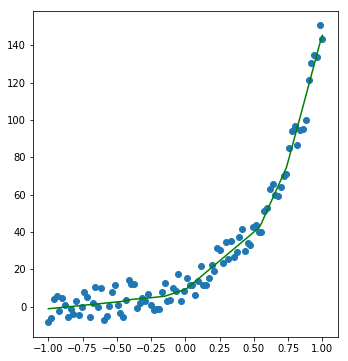

In [37]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=mse, learning_rate=1e-3, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y)
plt.plot(x, nn.predict(x), c='green')

## Classificação Binária

### Porta AND/OR

In [38]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 0, 0, 1]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.94998366 + 0.03118041 = 0.98116407 loss_val = 0.94998366
epoch:  100/1000 loss_train: 0.17238829 + 0.06545784 = 0.23784613 loss_val = 0.17238829
epoch:  200/1000 loss_train: 0.11207822 + 0.08847641 = 0.20055463 loss_val = 0.11207822
epoch:  300/1000 loss_train: 0.08816825 + 0.10112387 = 0.18929212 loss_val = 0.08816825
epoch:  400/1000 loss_train: 0.07570679 + 0.10909394 = 0.18480073 loss_val = 0.07570679
epoch:  500/1000 loss_train: 0.06829462 + 0.11446102 = 0.18275564 loss_val = 0.06829462
epoch:  600/1000 loss_train: 0.06353095 + 0.11821872 = 0.18174968 loss_val = 0.06353095
epoch:  700/1000 loss_train: 0.06031351 + 0.12091631 = 0.18122982 loss_val = 0.06031351
epoch:  800/1000 loss_train: 0.05806610 + 0.12288597 = 0.18095207 loss_val = 0.05806610
epoch:  900/1000 loss_train: 0.05645883 + 0.12434134 = 0.18080017 loss_val = 0.05645883
epoch: 1000/1000 loss_train: 0.05528979 + 0.12542592 = 0.18071571 loss_val = 0.05528979
[[5.01704 5.01704]] [[-7.89079]]

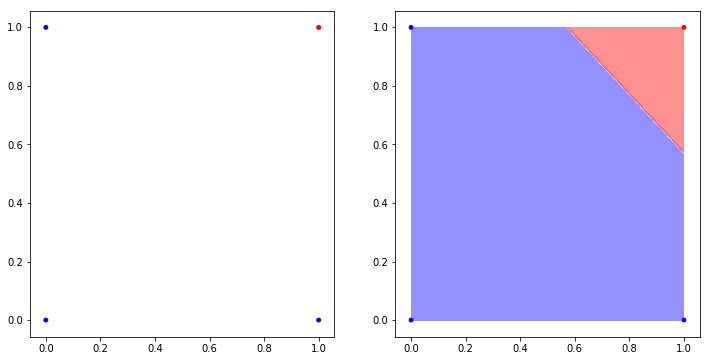

In [39]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=linear, reg_func=l1_regularization, reg_strength=0.05))

nn.fit(x, y, epochs=1000, verbose=100)

print(nn.layers[0].weights, nn.layers[0].biases)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, cmap='bwr')

### Porta XOR

In [40]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0]).reshape(-1, 1)

print(x.shape, y.shape)

(4, 2) (4, 1)


epoch:    0/1000 loss_train: 0.69947607 + 0.00000000 = 0.69947607 loss_val = 0.69947607
epoch:  100/1000 loss_train: 0.69349787 + 0.00000000 = 0.69349787 loss_val = 0.69349787
epoch:  200/1000 loss_train: 0.69187855 + 0.00000000 = 0.69187855 loss_val = 0.69187855
epoch:  300/1000 loss_train: 0.68346599 + 0.00000000 = 0.68346599 loss_val = 0.68346599
epoch:  400/1000 loss_train: 0.59356080 + 0.00000000 = 0.59356080 loss_val = 0.59356080
epoch:  500/1000 loss_train: 0.28536566 + 0.00000000 = 0.28536566 loss_val = 0.28536566
epoch:  600/1000 loss_train: 0.13627941 + 0.00000000 = 0.13627941 loss_val = 0.13627941
epoch:  700/1000 loss_train: 0.08322926 + 0.00000000 = 0.08322926 loss_val = 0.08322926
epoch:  800/1000 loss_train: 0.05864090 + 0.00000000 = 0.05864090 loss_val = 0.05864090
epoch:  900/1000 loss_train: 0.04487902 + 0.00000000 = 0.04487902 loss_val = 0.04487902
epoch: 1000/1000 loss_train: 0.03619451 + 0.00000000 = 0.03619451 loss_val = 0.03619451
Predições:
[[-3.40567]
 [ 3.1518

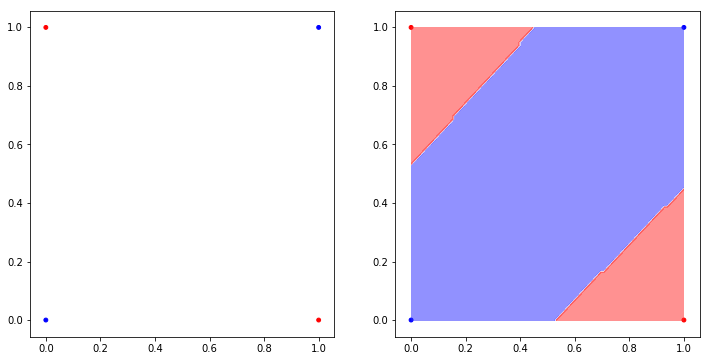

In [41]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=sigmoid_cross_entropy, learning_rate=1.0)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=sigmoid))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Predições:', y_pred, sep='\n')
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, cmap='bwr')

### 2 Clusters

In [42]:
x, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


epoch:    0/5000 loss_train: 4.47311529 + 0.00000000 = 4.47311529 loss_val = 4.47311529
epoch: 1000/5000 loss_train: 0.00628523 + 0.00000000 = 0.00628523 loss_val = 0.00628523
epoch: 2000/5000 loss_train: 0.00422239 + 0.00000000 = 0.00422239 loss_val = 0.00422239
epoch: 3000/5000 loss_train: 0.00334868 + 0.00000000 = 0.00334868 loss_val = 0.00334868
epoch: 4000/5000 loss_train: 0.00283535 + 0.00000000 = 0.00283535 loss_val = 0.00283535
epoch: 5000/5000 loss_train: 0.00248693 + 0.00000000 = 0.00248693 loss_val = 0.00248693
Acurácia: 100.00%


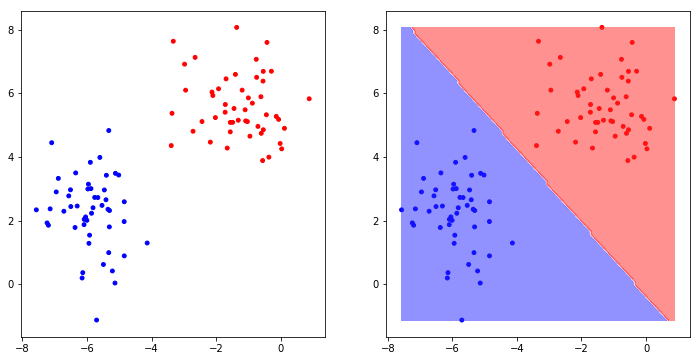

In [43]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=1000)

y_pred = nn.predict(x)

threshold = 0 if nn.layers[-1].activation == linear else 0.5
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred >= threshold)))
plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=threshold, cmap='bwr')

### 4 Clusters

In [44]:
x, y = make_blobs(n_samples=500, n_features=2, cluster_std=0.9, centers=[(-3, -3), (3, 3), (-3, 3), (3, -3)], random_state=1234)
y = y.reshape(-1, 1)
y = np.where(y >= 2, 1, 0)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/500 loss_train: 1.13895236 + 0.00000000 = 1.13895236 loss_val = 1.13895236
epoch:  100/500 loss_train: 0.00268719 + 0.00000000 = 0.00268719 loss_val = 0.00268719
epoch:  200/500 loss_train: 0.00124053 + 0.00000000 = 0.00124053 loss_val = 0.00124053
epoch:  300/500 loss_train: 0.00079079 + 0.00000000 = 0.00079079 loss_val = 0.00079079
epoch:  400/500 loss_train: 0.00057469 + 0.00000000 = 0.00057469 loss_val = 0.00057469
epoch:  500/500 loss_train: 0.00044888 + 0.00000000 = 0.00044888 loss_val = 0.00044888
Acurácia: 100.00%


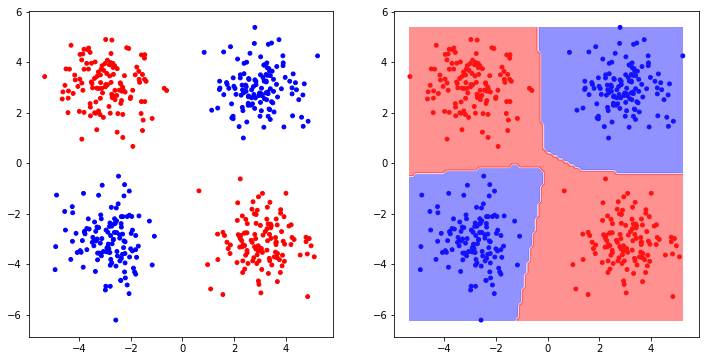

In [45]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=4, activation=relu))
nn.layers.append(Layer(input_dim=4, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=500, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Círculos

In [46]:
x, y = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


epoch:    0/1000 loss_train: 2.05608036 + 0.00000000 = 2.05608036 loss_val = 2.05608036
epoch:  100/1000 loss_train: 0.01735669 + 0.00000000 = 0.01735669 loss_val = 0.01735669
epoch:  200/1000 loss_train: 0.00883848 + 0.00000000 = 0.00883848 loss_val = 0.00883848
epoch:  300/1000 loss_train: 0.00592614 + 0.00000000 = 0.00592614 loss_val = 0.00592614
epoch:  400/1000 loss_train: 0.00440635 + 0.00000000 = 0.00440635 loss_val = 0.00440635
epoch:  500/1000 loss_train: 0.00346871 + 0.00000000 = 0.00346871 loss_val = 0.00346871
epoch:  600/1000 loss_train: 0.00283601 + 0.00000000 = 0.00283601 loss_val = 0.00283601
epoch:  700/1000 loss_train: 0.00238188 + 0.00000000 = 0.00238188 loss_val = 0.00238188
epoch:  800/1000 loss_train: 0.00204092 + 0.00000000 = 0.00204092 loss_val = 0.00204092
epoch:  900/1000 loss_train: 0.00177889 + 0.00000000 = 0.00177889 loss_val = 0.00177889
epoch: 1000/1000 loss_train: 0.00157136 + 0.00000000 = 0.00157136 loss_val = 0.00157136
Acurácia: 100.00%


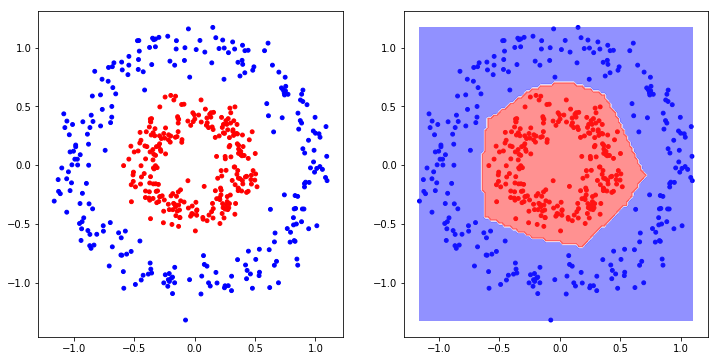

In [47]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=8, activation=relu))
nn.layers.append(Layer(input_dim=8, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=1000, verbose=100)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Moons

In [48]:
x, y = make_moons(200, noise=0.20)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/2000 loss_train: 1.39718610 + 0.00000000 = 1.39718610 loss_val = 1.39718610
epoch:  200/2000 loss_train: 0.27415335 + 0.00000000 = 0.27415335 loss_val = 0.27415335
epoch:  400/2000 loss_train: 0.16691212 + 0.00000000 = 0.16691212 loss_val = 0.16691212
epoch:  600/2000 loss_train: 0.12514458 + 0.00000000 = 0.12514458 loss_val = 0.12514458
epoch:  800/2000 loss_train: 0.10289869 + 0.00000000 = 0.10289869 loss_val = 0.10289869
epoch: 1000/2000 loss_train: 0.08643311 + 0.00000000 = 0.08643311 loss_val = 0.08643311
epoch: 1200/2000 loss_train: 0.07711559 + 0.00000000 = 0.07711559 loss_val = 0.07711559
epoch: 1400/2000 loss_train: 0.07278713 + 0.00000000 = 0.07278713 loss_val = 0.07278713
epoch: 1600/2000 loss_train: 0.07056927 + 0.00000000 = 0.07056927 loss_val = 0.07056927
epoch: 1800/2000 loss_train: 0.06925071 + 0.00000000 = 0.06925071 loss_val = 0.06925071
epoch: 2000/2000 loss_train: 0.06834913 + 0.00000000 = 0.06834913 loss_val = 0.06834913
Acurácia: 97.50%


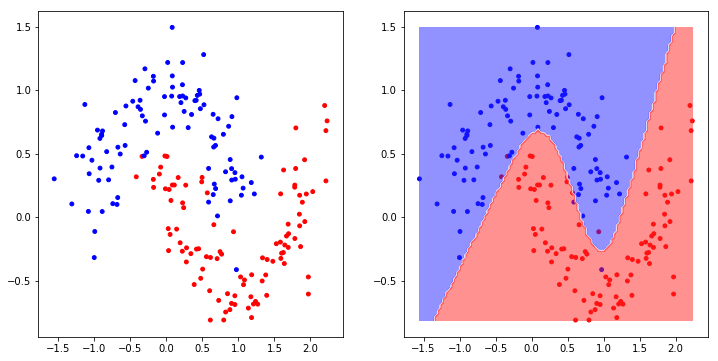

In [50]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=tanh))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=2000, verbose=200)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

### Espiral

In [51]:
x, y = make_spiral(n_samples=100, n_class=2, radius=5, laps=1.75)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(200, 2) (200, 1)


epoch:    0/5000 loss_train: 0.97243714 + 0.00000000 = 0.97243714 loss_val = 0.97243714
epoch:  500/5000 loss_train: 0.20352766 + 0.00000000 = 0.20352766 loss_val = 0.20352766
epoch: 1000/5000 loss_train: 0.04968354 + 0.00000000 = 0.04968354 loss_val = 0.04968354
epoch: 1500/5000 loss_train: 0.02134603 + 0.00000000 = 0.02134603 loss_val = 0.02134603
epoch: 2000/5000 loss_train: 0.01230491 + 0.00000000 = 0.01230491 loss_val = 0.01230491
epoch: 2500/5000 loss_train: 0.01125061 + 0.00000000 = 0.01125061 loss_val = 0.01125061
epoch: 3000/5000 loss_train: 0.00883085 + 0.00000000 = 0.00883085 loss_val = 0.00883085
epoch: 3500/5000 loss_train: 0.00795650 + 0.00000000 = 0.00795650 loss_val = 0.00795650
epoch: 4000/5000 loss_train: 0.00783032 + 0.00000000 = 0.00783032 loss_val = 0.00783032
epoch: 4500/5000 loss_train: 0.00994503 + 0.00000000 = 0.00994503 loss_val = 0.00994503
epoch: 5000/5000 loss_train: 0.00744083 + 0.00000000 = 0.00744083 loss_val = 0.00744083
Acurácia: 99.50%


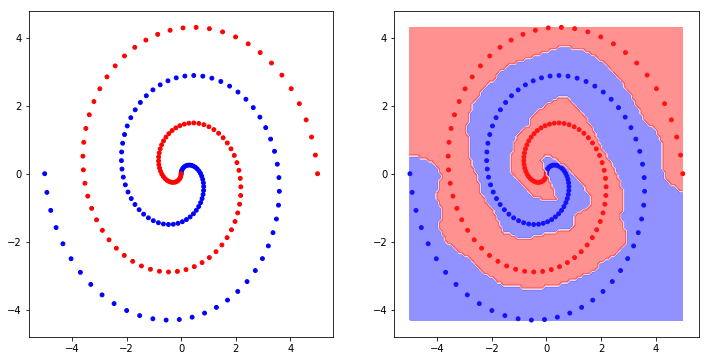

In [52]:
D_in, D_out = x.shape[1], y.shape[1]

nn = NeuralNetwork(cost_func=binary_cross_entropy, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=20, activation=tanh))
nn.layers.append(Layer(input_dim=20, output_dim=20, activation=tanh, dropout_prob=0.25))
nn.layers.append(Layer(input_dim=20, output_dim=D_out, activation=sigmoid))

nn.fit(x, y, epochs=5000, verbose=500)

y_pred = nn.predict(x)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=True, nn=nn, threshold=0.5, cmap='bwr')

## Classificação Multiclasse

### 3 Clusters Multiclasse

In [53]:
x, y = make_blobs(n_samples=300, n_features=2, centers=[(0, -3), (-3, 3), (3, 3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(300, 2) (300, 1)


In [54]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::60])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


epoch:    0/1000 loss_train: 1.46865533 + 0.00221878 = 1.47087411 loss_val = 1.46865533
epoch:  100/1000 loss_train: 0.52200508 + 0.01116147 = 0.53316655 loss_val = 0.52200508
epoch:  200/1000 loss_train: 0.49480751 + 0.01051228 = 0.50531980 loss_val = 0.49480751
epoch:  300/1000 loss_train: 0.48446490 + 0.00990430 = 0.49436920 loss_val = 0.48446490
epoch:  400/1000 loss_train: 0.47905030 + 0.00933380 = 0.48838410 loss_val = 0.47905030
epoch:  500/1000 loss_train: 0.47564961 + 0.00879966 = 0.48444927 loss_val = 0.47564961
epoch:  600/1000 loss_train: 0.13029051 + 0.00909690 = 0.13938741 loss_val = 0.13029051
epoch:  700/1000 loss_train: 0.04362504 + 0.00883819 = 0.05246323 loss_val = 0.04362504
epoch:  800/1000 loss_train: 0.02564767 + 0.00844651 = 0.03409418 loss_val = 0.02564767
epoch:  900/1000 loss_train: 0.01816769 + 0.00807772 = 0.02624540 loss_val = 0.01816769
epoch: 1000/1000 loss_train: 0.01411202 + 0.00773530 = 0.02184732 loss_val = 0.01411202
[[-1.15501 -5.60197]
 [ 2.00462 

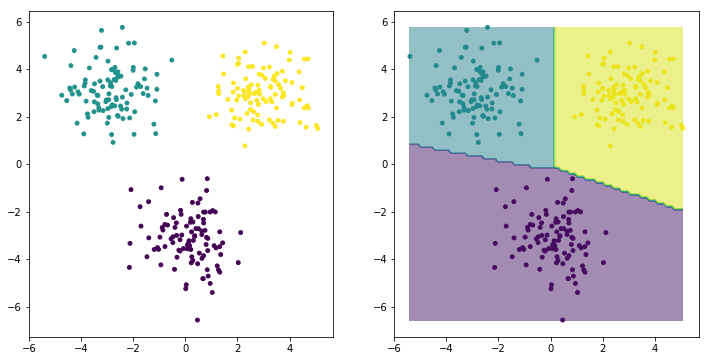

In [55]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu, reg_func=l2_regularization, reg_strength=0.1))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear, reg_func=l2_regularization, reg_strength=0.1))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

for layer in nn.layers:
    print(layer.weights)
    
y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### 4 Clusters Multiclasse

In [56]:
x, y = make_blobs(n_samples=400, n_features=2, centers=[(-3, 0), (3, 0), (0, 3), (0, -3)], random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(400, 2) (400, 1)


In [57]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::70])

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]]


epoch:    0/1000 loss_train: 1.70958799 + 0.00000000 = 1.70958799 loss_val = 1.70958799
epoch:  100/1000 loss_train: 0.18319131 + 0.00000000 = 0.18319131 loss_val = 0.18319131
epoch:  200/1000 loss_train: 0.12721288 + 0.00000000 = 0.12721288 loss_val = 0.12721288
epoch:  300/1000 loss_train: 0.10756112 + 0.00000000 = 0.10756112 loss_val = 0.10756112
epoch:  400/1000 loss_train: 0.09804952 + 0.00000000 = 0.09804952 loss_val = 0.09804952
epoch:  500/1000 loss_train: 0.09234222 + 0.00000000 = 0.09234222 loss_val = 0.09234222
epoch:  600/1000 loss_train: 0.08815362 + 0.00000000 = 0.08815362 loss_val = 0.08815362
epoch:  700/1000 loss_train: 0.08514846 + 0.00000000 = 0.08514846 loss_val = 0.08514846
epoch:  800/1000 loss_train: 0.08284329 + 0.00000000 = 0.08284329 loss_val = 0.08284329
epoch:  900/1000 loss_train: 0.08110362 + 0.00000000 = 0.08110362 loss_val = 0.08110362
epoch: 1000/1000 loss_train: 0.07982340 + 0.00000000 = 0.07982340 loss_val = 0.07982340
Acurácia: 96.50%


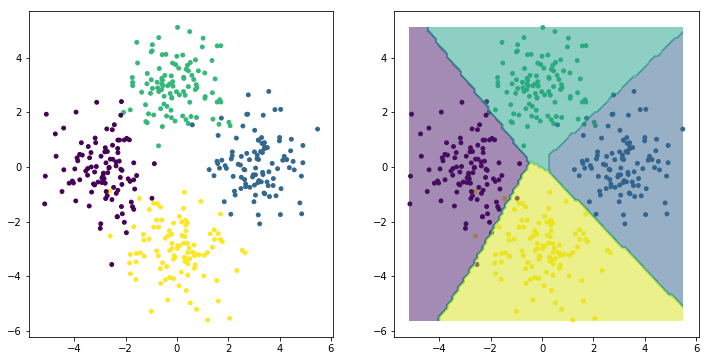

In [58]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=3, activation=relu))
nn.layers.append(Layer(input_dim=3, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Espiral - 5 Classes

In [59]:
x, y = make_spiral(n_samples=100, n_class=5, radius=1, laps=0.5)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(500, 2) (500, 1)


In [60]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::100])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


epoch:    0/2000 loss_train: 6.48759213 + 0.00000000 = 6.48759213 loss_val = 6.48759213
epoch:  200/2000 loss_train: 0.78313251 + 0.00000000 = 0.78313251 loss_val = 0.78313251
epoch:  400/2000 loss_train: 0.55591563 + 0.00000000 = 0.55591563 loss_val = 0.55591563
epoch:  600/2000 loss_train: 0.42166265 + 0.00000000 = 0.42166265 loss_val = 0.42166265
epoch:  800/2000 loss_train: 0.35255885 + 0.00000000 = 0.35255885 loss_val = 0.35255885
epoch: 1000/2000 loss_train: 0.30455796 + 0.00000000 = 0.30455796 loss_val = 0.30455796
epoch: 1200/2000 loss_train: 0.27051459 + 0.00000000 = 0.27051459 loss_val = 0.27051459
epoch: 1400/2000 loss_train: 0.24104716 + 0.00000000 = 0.24104716 loss_val = 0.24104716
epoch: 1600/2000 loss_train: 0.21545725 + 0.00000000 = 0.21545725 loss_val = 0.21545725
epoch: 1800/2000 loss_train: 0.19230702 + 0.00000000 = 0.19230702 loss_val = 0.19230702
epoch: 2000/2000 loss_train: 0.14660583 + 0.00000000 = 0.14660583 loss_val = 0.14660583
Acurácia: 95.20%


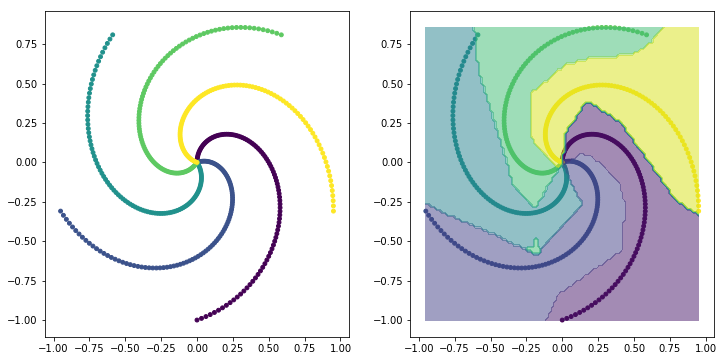

In [62]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1)
nn.layers.append(Layer(input_dim=D_in, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=10, activation=relu))
nn.layers.append(Layer(input_dim=10, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Make Classification - 4 Classes

In [63]:
x, y = make_classification(n_samples=100, n_classes=4, n_features=2, n_clusters_per_class=1, n_redundant=0, n_repeated=0, random_state=1234)
y = y.reshape(-1, 1)

print(x.shape, y.shape)

(100, 2) (100, 1)


In [64]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::10])

[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


epoch:    0/1000 loss_train: 4.50658616 + 0.00000000 = 4.50658616 loss_val = 4.50658616
epoch:  100/1000 loss_train: 0.26572480 + 0.00000000 = 0.26572480 loss_val = 0.26572480
epoch:  200/1000 loss_train: 0.21122309 + 0.00000000 = 0.21122309 loss_val = 0.21122309
epoch:  300/1000 loss_train: 0.18505488 + 0.00000000 = 0.18505488 loss_val = 0.18505488
epoch:  400/1000 loss_train: 0.16833834 + 0.00000000 = 0.16833834 loss_val = 0.16833834
epoch:  500/1000 loss_train: 0.14148506 + 0.00000000 = 0.14148506 loss_val = 0.14148506
epoch:  600/1000 loss_train: 0.12521624 + 0.00000000 = 0.12521624 loss_val = 0.12521624
epoch:  700/1000 loss_train: 0.11542148 + 0.00000000 = 0.11542148 loss_val = 0.11542148
epoch:  800/1000 loss_train: 0.10805617 + 0.00000000 = 0.10805617 loss_val = 0.10805617
epoch:  900/1000 loss_train: 0.10226912 + 0.00000000 = 0.10226912 loss_val = 0.10226912
epoch: 1000/1000 loss_train: 0.09775532 + 0.00000000 = 0.09775532 loss_val = 0.09775532
Acurácia: 95.00%


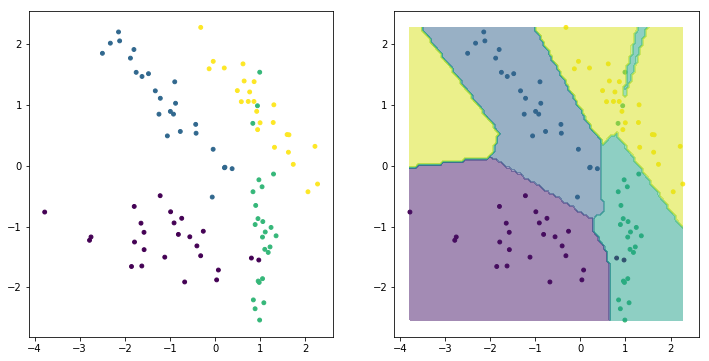

In [65]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=5, activation=relu))
nn.layers.append(Layer(input_dim=5, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=1000, verbose=100)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

### Iris Dataset

In [66]:
data = load_iris()
x, y = data.data[:, 2:], data.target.reshape(-1,1)

print(data.feature_names)
print(data.target_names)
print(x.shape, y.shape)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
(150, 2) (150, 1)


In [67]:
onehot = OneHotEncoder(sparse=False)
y_onehot = onehot.fit_transform(y)
print(y_onehot[::20])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


epoch:    0/2000 loss_train: 1.07131849 + 0.00000000 = 1.07131849 loss_val = 1.07131849
epoch:  200/2000 loss_train: 0.36652813 + 0.00000000 = 0.36652813 loss_val = 0.36652813
epoch:  400/2000 loss_train: 0.27299881 + 0.00000000 = 0.27299881 loss_val = 0.27299881
epoch:  600/2000 loss_train: 0.22530533 + 0.00000000 = 0.22530533 loss_val = 0.22530533
epoch:  800/2000 loss_train: 0.19539551 + 0.00000000 = 0.19539551 loss_val = 0.19539551
epoch: 1000/2000 loss_train: 0.17365313 + 0.00000000 = 0.17365313 loss_val = 0.17365313
epoch: 1200/2000 loss_train: 0.15802212 + 0.00000000 = 0.15802212 loss_val = 0.15802212
epoch: 1400/2000 loss_train: 0.14650368 + 0.00000000 = 0.14650368 loss_val = 0.14650368
epoch: 1600/2000 loss_train: 0.13765324 + 0.00000000 = 0.13765324 loss_val = 0.13765324
epoch: 1800/2000 loss_train: 0.13061966 + 0.00000000 = 0.13061966 loss_val = 0.13061966
epoch: 2000/2000 loss_train: 0.12488141 + 0.00000000 = 0.12488141 loss_val = 0.12488141
Acurácia: 96.00%


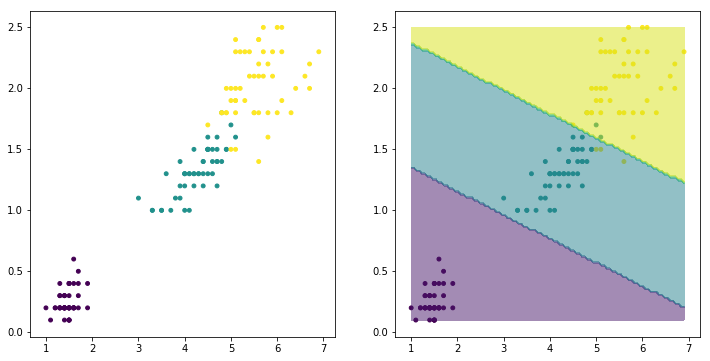

In [69]:
D_in, D_out = x.shape[1], y_onehot.shape[1]

nn = NeuralNetwork(cost_func=softmax_neg_log_likelihood, learning_rate=1e-1, momentum=0.9)
nn.layers.append(Layer(input_dim=D_in, output_dim=2, activation=relu))
nn.layers.append(Layer(input_dim=2, output_dim=D_out, activation=linear))

nn.fit(x, y_onehot, epochs=2000, verbose=200)

y_pred = np.argmax(nn.predict(x), axis=1)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred)))

plots.plot_data_and_predictions_3d_in_2d(x, y, is_binary=False, nn=nn)

# Referências

- [Tensorflow Playground](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.94880&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

- [Linear Classification](http://cs231n.github.io/linear-classify/)

__Regularization__:
- [Implementing Neural Network L1 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/27/implementing-neural-network-l1-regularization/)
- [Implementing Neural Network L2 Regularization](https://jamesmccaffrey.wordpress.com/2017/06/29/implementing-neural-network-l2-regularization/)
- [Neural Network L2 Regularization Using Python](https://visualstudiomagazine.com/articles/2017/09/01/neural-network-l2.aspx)

__Momentum__:
- [Neural Network Momentum Using Python](https://visualstudiomagazine.com/articles/2017/08/01/neural-network-momentum.aspx)
- [Beyond SGD: Gradient Descent with Momentum and Adaptive Learning Rate](https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/)

__Learning Rate Decay__:
- [Using Learning Rate Schedules for Deep Learning Models in Python with Keras](https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/)
- [Learning Rate Schedules and Adaptive Learning Rate Methods for Deep Learning](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
- [Tensorflow Exponential Decay Documentation](https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay)

__Batch Normalization__:
- [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
- [Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
- [Implementing BatchNorm in Neural Net](https://wiseodd.github.io/techblog/2016/07/04/batchnorm/)
- [What does the gradient flowing through batch normalization looks like ?](http://cthorey.github.io./backpropagation/)
- [GRADIENTS, BATCH NORMALIZATION AND LAYER NORMALIZATION](https://theneuralperspective.com/2016/10/27/gradient-topics/)

__Gradient Checking__:
- [cs231n](https://github.com/cs231n/cs231n.github.io/blob/master/neural-networks-3.md#gradcheck)
- [Gradient checking and advanced optimization](http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization)
- [BatchNormalization fails gradient checking](https://github.com/torch/nn/issues/744)

__NOTAS__:

__Inicialização dos pesos__:
- mostrar a documentação das funções np.random.rand e np.random.randn para mostrar como gerar distribuições na faixa [-limit, limit] e com média zero e certo desvio-padrão.
- mostrar que os métodos de inicialização de pesos ones e random_uniform podem não ser adequados para alguns problemas, como o do espiral binário.

__Regularização__:
- mostrar que a regularização dos pesos nem sempre ajuda. Em alguns casos, como o espiral multiclasse, temos que definir a reg_strength muito pequena. Isto é, estamos dizendo que o valores dos pesos não podem influenciar no custo. Em outras palavras, isso é a mesma coisa que "desligar" a regularização.
- temos de ter muito cuidado ao fazer a checkagem do gradiente com regularização L1/L2. Muitas implementações esquecem de adicionar o custo da regularização na checkagem do gradiente. Isso pode fazer você pensar que a implementação está errada.

__Learning Rate Decay__:
- mostrar que a staircase_decay e exponential_decay tem praticamente a mesma fórmula, com exceção de decay_steps. Na própria documentação do Tensorflow, eles implementam as duas no mesmo método.